In [ ]:
import yfinance as yf, pandas as pd, numpy as np
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from pykalman import KalmanFilter
import get_data as gd
import cointegration_tests as ct
import backtest_helpers as bh
import mplcyberpunk




Engle-Granger Test - ✅ Good for Cointegration

KPSS Test - ✅ Good for Cointegration

2023-01-03: Entered inward position - shorted MSFT with 401 shares and longed NVDA with 400 shares
2023-01-05: Exited trade due to: Take profit hit
PnL from trade: $6767.36

2023-01-06: Entered outward position - longed MSFT with 454 shares and shorted NVDA with 448 shares
2023-01-13: Exited trade due to: Max trade duration reached
PnL from trade: $5449.75

2023-01-17: Entered outward position - longed MSFT with 444 shares and shorted NVDA with 420 shares
2023-01-24: Exited trade due to: Max trade duration reached
PnL from trade: $79.49

2023-01-25: Entered outward position - longed MSFT with 443 shares and shorted NVDA with 402 shares
2023-02-01: Exited trade due to: Z-score mean reversion
PnL from trade: $4620.22

2023-02-02: Entered inward position - shorted MSFT with 419 shares and longed NVDA with 373 shares
2023-02-09: Exited trade due to: Max trade duration reached
PnL from trade: $636.48

2023

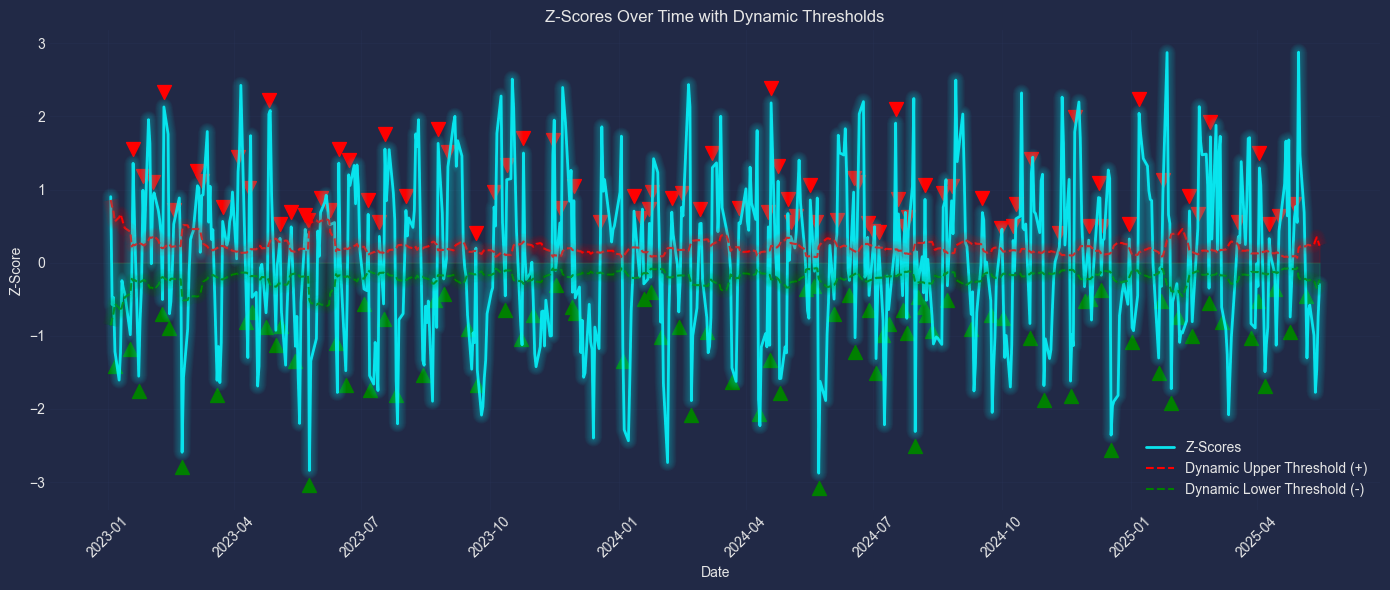

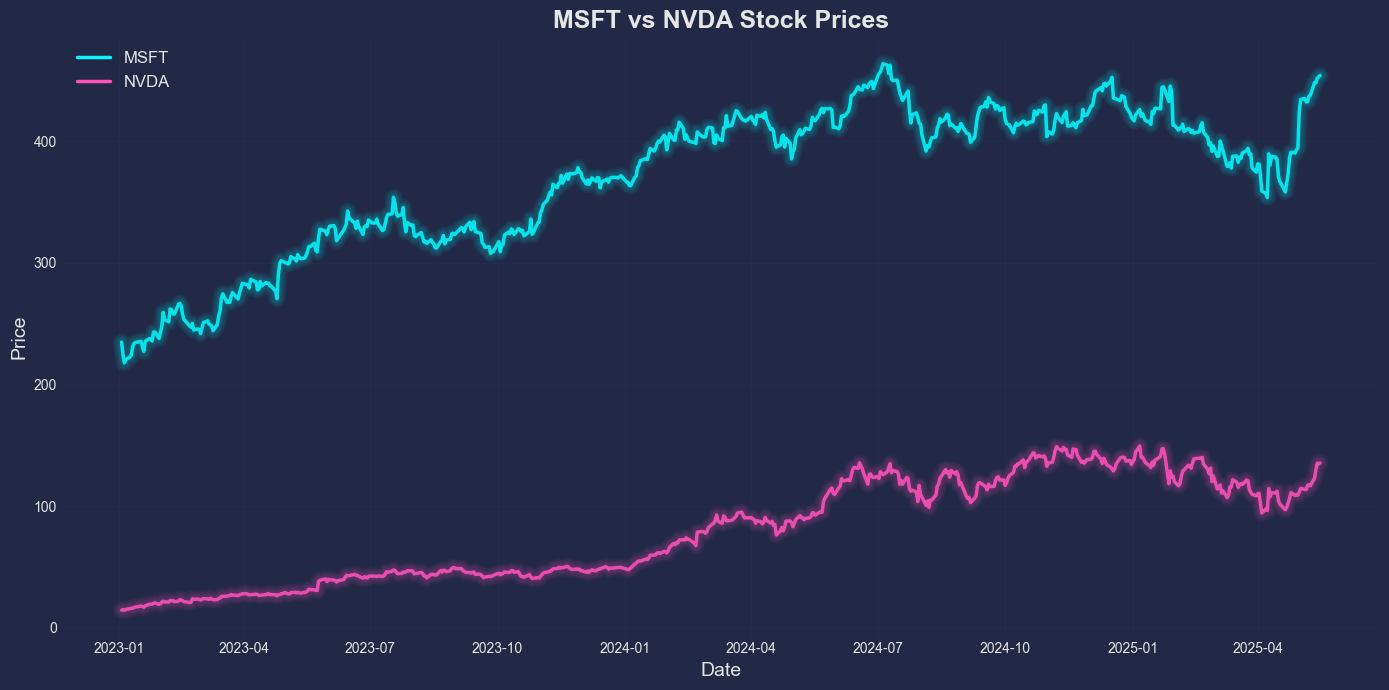

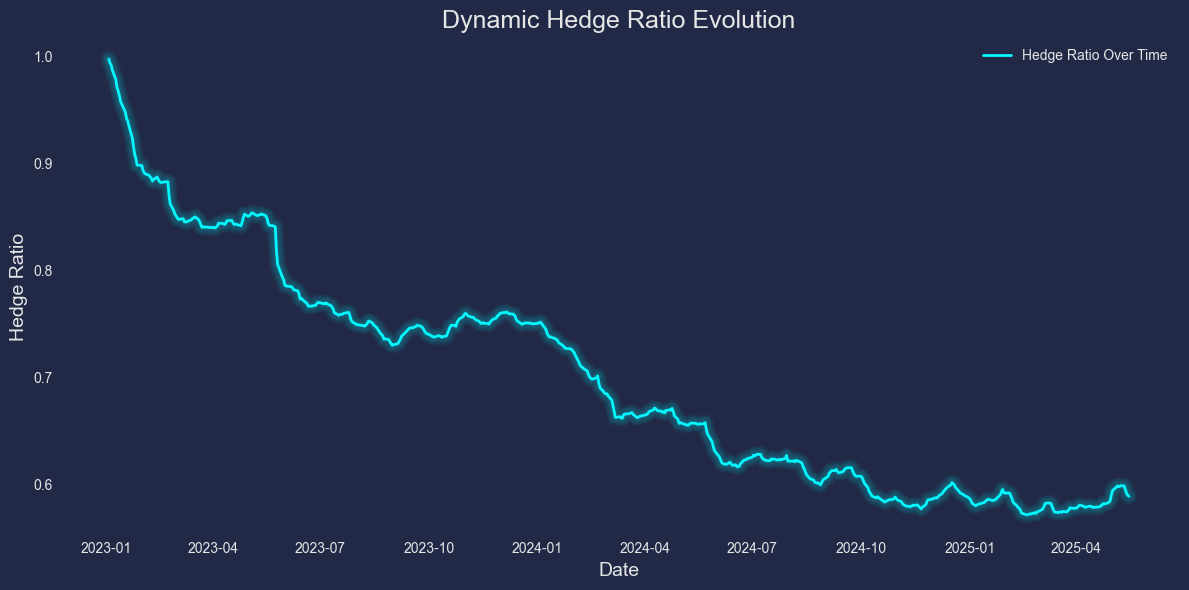

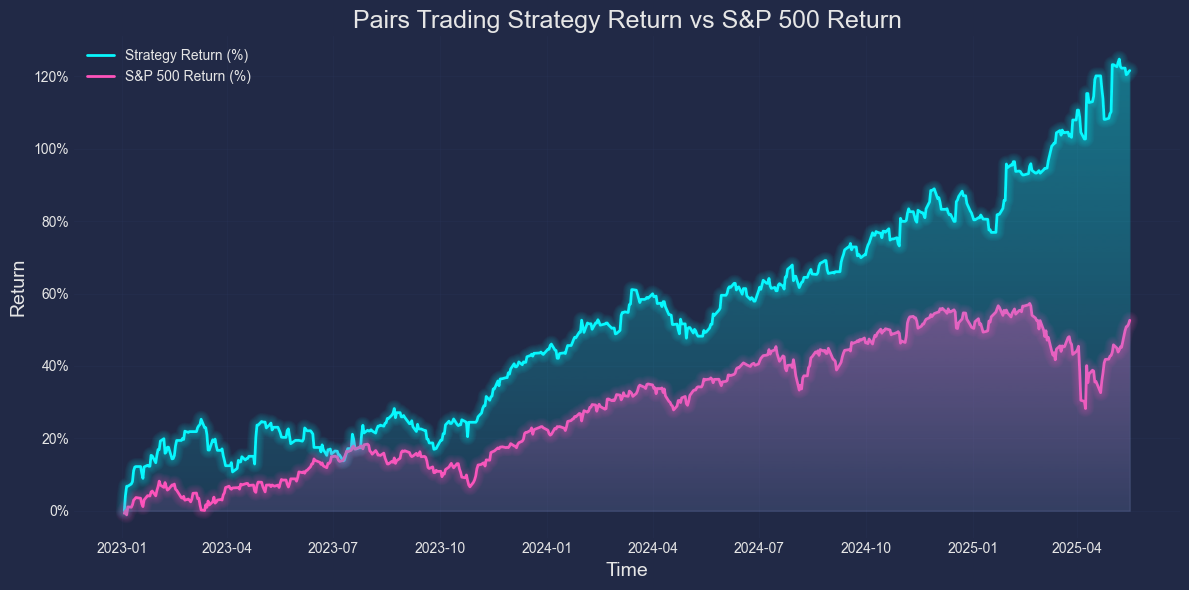

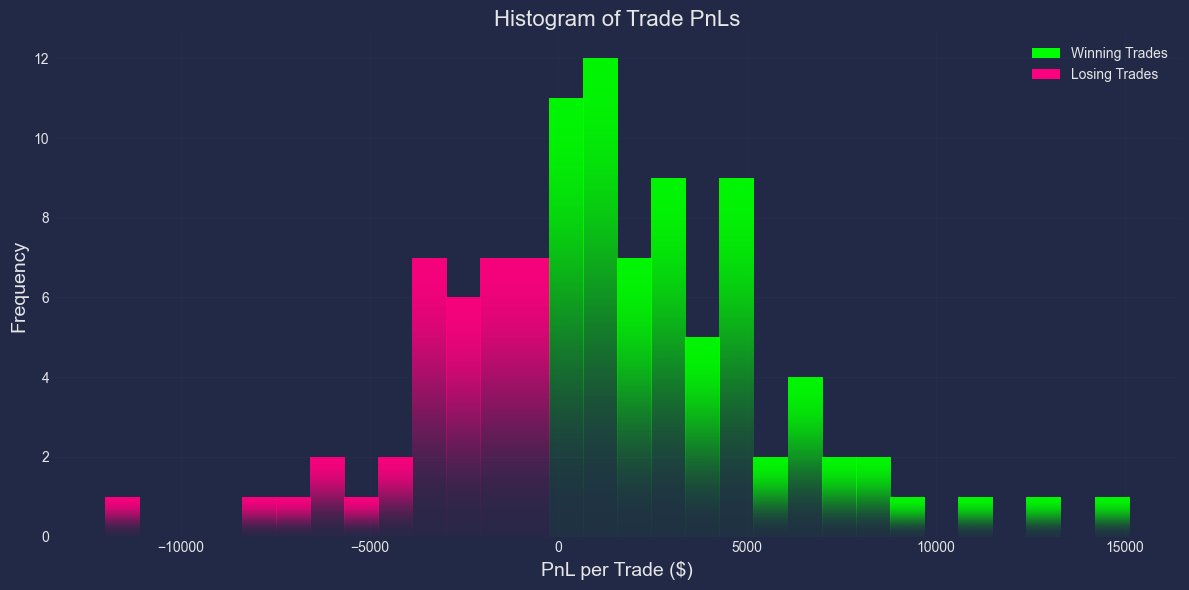

In [2]:

def backtest(tickers, train_dates, test_dates, base_threshold, base_exit_threshold, 
             available_capital, max_trade_duration, stop_loss_percent, take_profit_percent, interval="1d"):
    """
    Backtesting Engine - backtests the dynamic pairs trading strategy, putting together all the components. 
    Args:
        tickers (list): list of two stock tickers (e.g. ['AAPL', 'MSFT'])
        train_dates (list): list of two dates (e.g. ['2020-01-01', '2022-12-31']) for training data
        test_dates (list): list of two dates (e.g. ['2023-01-01', '2025-05-14']) for testing data
        base_threshold (float): the z-score threshold for entering a trade
        base_exit_threshold (float): the z-score threshold for exiting a trade
        available_capital (float): the amount of capital available for trading
        max_trade_duration (int): the maximum number of days to stay in a trade
        stop_loss_percent (float): the percentage loss at which to exit a trade
        take_profit_percent (float): the percentage gain at which to exit a trade
        interval (str): the time interval for the stock data (e.g. '1d', '1h', etc.)
    Returns:
        None
    This function performs the following steps:
    1. Fetches the training data for the specified tickers and dates.
    2. Performs cointegration tests on the training data.
    3. Calculates the hedge ratio using the training data.
    4. Fetches the testing data for the specified tickers and dates.
    5. Initializes variables for tracking trades, positions, and PnL.
    6. Iterates through the testing data, calculating the spread and z-scores
    7. Updates the hedge ratio and intercept using a Kalman filter.
    8. Checks for entry and exit signals based on the z-score and dynamic thresholds along with risk management techniques.
    9. Calculates the total PnL and other performance metrics.
    10. Plots the results, including z-scores, stock prices, hedge ratios, PnL, etc.
    """

    #get training data

    t1 = tickers[0]
    t2 = tickers[1]

    train_data = gd.get_price(tickers, train_dates, interval)
    train_log = np.log(train_data)
    
    #make first column higher priced stock 
    if train_data.iloc[1, 1] > train_data.iloc[1, 0]:
        tickers = [t2, t1]
        train_data = gd.get_price(tickers, train_dates, interval)
        train_log = np.log(train_data)
        t1, t2 = t2, t1

    #perform cointegration tests
    print (""); ct.engle_granger_test(train_log)
    print (""); ct.kpss_test(train_log); print ("")
   
    # Prepare historical log prices for kalman filter
    log_t1 = train_log[t1]
    log_t2 = train_log[t2]
    last_state_mean, last_state_cov = bh.initial_kalman_hedge(log_t1, log_t2)
    
    # Extract historical hedge ratio and intercept
    historical_hedge_ratio = last_state_mean[0]
    historical_intercept = last_state_mean[1]

    # Calculate historical spread
    train_log["Spread"] = train_log[t1] - (historical_hedge_ratio * train_log[t2]) - historical_intercept

    # Calculate historical spread mean and standard deviation
    historical_spread_mean = train_log["Spread"].mean()
    historical_spread_sigma = train_log["Spread"].std()
    
    #get testing data
    test_data = gd.get_price(tickers, test_dates, interval)
    test_log = np.log(test_data)

    #Initalize variables to keep track of trades, positions, PnL, etc. 
    zscores = []
    rolling_spreads = list(train_log["Spread"].iloc[-10:])
    in_trade = False
    position = None
    pnl = 0
    capital = available_capital
    num_trades = 0
    trades = []
    constant_pnl = []
    hedge_ratios_list = []
    dynamic_entry_thresholds = []
    dynamic_exit_thresholds = []
    days_in_trade = 0
    percent_change = 0

    #loop through test data, simulating trades

    for ind in range(len(test_data)):

        if in_trade:
            days_in_trade += 1

        current_t1_log_price = test_log.iloc[ind][t1]
        current_t2_log_price = test_log.iloc[ind][t2]

        # One-step Kalman filter update for hedge ratio and intercept
        lsm, lsc, hedge_r, hedge_intercept = bh.kalman_update(last_state_mean, last_state_cov, \
                                                              current_t1_log_price, current_t2_log_price)

        last_state_mean = lsm
        last_state_cov = lsc

        # Extract hedge ratio and intercept
        hedge_ratio = hedge_r
        intercept = hedge_intercept

        hedge_ratios_list.append(hedge_ratio)

        # Calculate the spread using the updated hedge ratio and intercept
        spread = test_log.loc[test_log.index[ind], t1] - (hedge_ratio * test_log.loc[test_log.index[ind], t2]) - intercept
        rolling_spreads.append(spread)

        #calculate mean of spreads based on last 10 datapoints
        rolling_mean = np.mean(rolling_spreads[-10:])
        rolling_sigma = np.std(rolling_spreads[-10:])
        
        #make the thresholds dynamic, based on the input
        #scale the base threshold by the ratio of the rolling std dev to the historical std dev
        threshold = base_threshold * (rolling_sigma / historical_spread_sigma) 
        exit_threshold = base_exit_threshold

        dynamic_entry_thresholds.append(threshold)
        dynamic_exit_thresholds.append(exit_threshold)

        # Calculate the z-score using the rolling mean and std dev
        z_score = (spread - rolling_mean) / rolling_sigma
        zscores.append(z_score)

        if z_score >= threshold and not in_trade:

            #short t1, long t2 ("inward" trade)

            t1_entry = test_data.iloc[ind][t1]
            t2_entry = test_data.iloc[ind][t2]

            #Calculate number of shares
            t1_shares = int(np.floor(capital / (t1_entry + (t2_entry * hedge_ratio))))
            t2_shares = int(np.floor(t1_shares * hedge_ratio))

            position = "inward"

            str_date = test_data.index[ind].strftime("%Y-%m-%d")
            print (f"{str_date}: Entered inward position - shorted {t1} with {t1_shares} shares and longed {t2} with {t2_shares} shares")
            in_trade = True

        elif z_score <= (-1*threshold) and not in_trade:

            #short t2, long t1 ("outward" trade)

            t1_entry = test_data.iloc[ind][t1]
            t2_entry = test_data.iloc[ind][t2]

            #Calculate number of shares
            t1_shares = int(np.floor(capital / (t1_entry + (t2_entry * hedge_ratio))))
            t2_shares = int(np.floor(t1_shares * hedge_ratio))

            position = "outward"
            str_date = test_data.index[ind].strftime("%Y-%m-%d")

            print (f"{str_date}: Entered outward position - longed {t1} with {t1_shares} shares and shorted {t2} with {t2_shares} shares")
            in_trade = True

        #track portfolio value with realized and unrealized PnL

        realized_pnl = sum(trades)

        if not in_trade:
            constant_pnl.append(realized_pnl)
        else:
            current_t1_price = test_data.loc[test_data.index[ind], t1]
            current_t2_price = test_data.loc[test_data.index[ind], t2]

            if position == "inward":
                unrealized_pnl = ((t1_shares*(t1_entry - current_t1_price)) + (t2_shares*(current_t2_price - t2_entry)))
            else: #outward
                unrealized_pnl = ((t1_shares*(current_t1_price - t1_entry)) + (t2_shares*(t2_entry - current_t2_price)))

            constant_pnl.append(realized_pnl + unrealized_pnl)
            percent_change = (unrealized_pnl / capital)

        #condition checking for exiting trade
        should_exit = lambda \
            z_score, exit_threshold, days_in_trade, max_trade_duration, \
            percent_change, stop_loss_percent, take_profit_percent: \
            (np.abs(z_score) <= exit_threshold) or (days_in_trade >= max_trade_duration) or \
            (percent_change <= -stop_loss_percent) or (percent_change >= take_profit_percent)
        
        if in_trade and should_exit(z_score, exit_threshold, days_in_trade, max_trade_duration, \
            percent_change, stop_loss_percent, take_profit_percent):
            #Exit trade            
            if np.abs(z_score) <= exit_threshold:
                reason = "Z-score mean reversion"
            elif days_in_trade >= max_trade_duration:
                reason = "Max trade duration reached"
            elif percent_change <= -stop_loss_percent:
                reason = "Stop loss hit"
            elif percent_change >= take_profit_percent:
                reason = "Take profit hit"

            num_trades += 1

            #Calculate PnL
            t1_exit = test_data.iloc[ind][t1]
            t2_exit = test_data.iloc[ind][t2]
            if position == "inward":
                #buy to cover t1, sell t2
                net = ((t1_shares*(t1_entry - t1_exit)) + (t2_shares*(t2_exit - t2_entry)))
                pnl += net
            else: #outward position
                net = ((t1_shares*(t1_exit - t1_entry)) + (t2_shares*(t2_entry - t2_exit)))
                pnl += net
            #update capital
            capital += net

            # trades is dictionary - date : pnl from trade
            trades.append(net)

            str_date = test_data.index[ind].strftime("%Y-%m-%d")
            print(f"{str_date}: Exited trade due to: {reason}"); print (f"PnL from trade: ${round(net, 2)}"); print ("")

            in_trade = False
            position = None
            days_in_trade = 0  
    
    #Calculate and output performance metrics and plots

    sharpe_ratio = bh.calculate_sharpe(constant_pnl)

    calculate_win_rate = lambda trades: np.sum(np.array(trades) > 0) / len(trades) if len(trades) > 0 else 0.0
    win_rate = calculate_win_rate(trades)
    
    print (""); print (f"Total trades: {num_trades}")
    print (""); print (f"Total Realized PnL: ${round(pnl, 2)}")
    print (""); print (f"Percent Returns (Realized): {round(100 * (pnl / available_capital), 2)}%")
    print (""); print (f"Win Rate: {round(100 * win_rate)}%")
    print (""); print (f"Sharpe Ratio: {round(sharpe_ratio, 2)}"); print ("")

    bh.plot_z_scores(zscores, dynamic_entry_thresholds, test_data.index.tolist())
    bh.plot_stocks(test_data, t1, t2)
    bh.plot_hedge_ratio(hedge_ratios_list, test_data.index.tolist())
    bh.plot_pnl(constant_pnl, test_dates, available_capital, test_data.index.tolist())
    bh.plot_trade_pnl(trades)


#Usage
tickers = ['MSFT', 'NVDA']
train_dates = ['2020-01-01', '2022-12-31']
test_dates = ['2023-01-01', '2025-05-19']
threshold = 4
exit_threshold = 0.05
capital = 100000
max_trade_duration = 5
stop_loss_percent = 0.03
take_profit_percent = 0.06

backtest(tickers, train_dates, test_dates, threshold, exit_threshold, capital, max_trade_duration, \
         stop_loss_percent, take_profit_percent, interval="1d")
